<a href="https://colab.research.google.com/github/TadikondaMythri/96_Mythri/blob/main/financial_sentiment_analysis_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install -U langchain langchain-community langchain-openai

In [70]:
!pip install -U langchain

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# 1. Download latest version of the dataset via kagglehub
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")
print("Path to dataset files:", path)

# Dynamically set the CSV path (handles different OS directory structures)
csv_file_path = os.path.join(path, "all-data.csv")

# 2. Load data (using encoding 'latin-1' as required for this specific dataset)
df = pd.read_csv(csv_file_path, encoding='latin-1', names=['sentiment', 'text'])

# 3. Basic Cleaning
df = df.drop_duplicates()
print(f"Dataset Shape: {df.shape}")

# 4. Label Encoding (Neutral: 1, Negative: 0, Positive: 2)
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# 5. Split data (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print("Preprocessing complete. Training and testing sets are ready.")

Using Colab cache for faster access to the 'sentiment-analysis-for-financial-news' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-financial-news
Dataset Shape: (4840, 2)
Preprocessing complete. Training and testing sets are ready.


In [72]:
# STEP 2: Financial Sentiment Prompt (LangChain Core)

ALLOWED_LABELS = {"Positive", "Negative", "Neutral"}

financial_prompt = PromptTemplate(
    template="""
You are a financial market analyst.

Task:
Classify the sentiment of the following financial news strictly
from a market impact perspective.

Rules:
- Focus on revenue, profit, growth, risk, guidance
- Ignore emotional or promotional language
- Respond with exactly one word: Positive, Negative, or Neutral.
- Do not add explanations.

News:
{text}
""",
    input_variables=["text"]
)


In [73]:
# STEP 3,4: Zero-Shot LLM Evaluation using HuggingFace FinBERT (FINAL)

import pandas as pd
from transformers import pipeline

# 1. Prepare test dataframe
test_df = pd.DataFrame({
    "text": X_test.values,
    "true_sentiment": le.inverse_transform(y_test)
})

# 2. Create a balanced sample across sentiment classes
samples_per_class = 15  # can be adjusted
balanced_sample = (
    test_df
    .groupby("true_sentiment", group_keys=False)
    .sample(n=samples_per_class, random_state=42)
    .reset_index(drop=True)
)

# 3. Initialize zero-shot sentiment model (finance domain)
zero_shot_classifier = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)

# 4. Run zero-shot inference
llm_predictions = []

for text in balanced_sample["text"]:
    try:
        result = zero_shot_classifier(text)[0]
        label = result["label"].lower()

        if "positive" in label:
            sentiment = "positive"
        elif "negative" in label:
            sentiment = "negative"
        else:
            sentiment = "neutral"

    except Exception:
        sentiment = "neutral"

    llm_predictions.append(sentiment)

# 5. Build zero-shot analysis table
zero_shot_df = pd.DataFrame({
    "text": balanced_sample["text"].values,
    "true_sentiment": balanced_sample["true_sentiment"].values,
    "llm_prediction": llm_predictions
})

# 6. Correctness flag
zero_shot_df["is_correct"] = (
    zero_shot_df["llm_prediction"].str.lower()
    == zero_shot_df["true_sentiment"].str.lower()
)

print(
    "Zero-shot LLM accuracy on balanced sample:",
    zero_shot_df["is_correct"].mean()
)

zero_shot_df


Device set to use cpu


Zero-shot LLM accuracy on balanced sample: 0.9555555555555556


,text,true_sentiment,llm_prediction,is_correct
0,"Budapest , August 10 MTI - Finnish electronics...",negative,negative,True
1,Scanfil has also issued a profit warning .,negative,negative,True
2,The measures result from weak demand in the sh...,negative,negative,True
3,"In a media advisory , the NTSB said that after...",negative,negative,True
4,Food sales totalled EUR 323.5 mn in October 20...,negative,negative,True
5,Cramo slipped to a pretax loss of EUR 6.7 mill...,negative,negative,True
6,It is a disappointment to see the plan folded .,negative,negative,True
7,Earnings per share ( EPS ) in the first half o...,negative,negative,True
8,"In January-November 2009 , the group 's sales ...",negative,negative,True
9,`` There 's the issue of thieves stealing them...,negative,negative,True


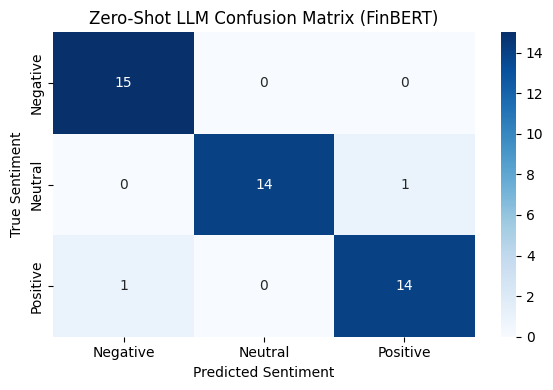

In [74]:
# STEP 4B: LLM Zero-Shot Confusion Matrix (FINAL, ROBUST)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize labels to a common format
y_true_llm = zero_shot_df["true_sentiment"].str.capitalize()
y_pred_llm = zero_shot_df["llm_prediction"].str.capitalize()

LABELS = ["Negative", "Neutral", "Positive"]

cm_llm = confusion_matrix(
    y_true_llm,
    y_pred_llm,
    labels=LABELS
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_llm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=LABELS,
    yticklabels=LABELS
)

plt.title("Zero-Shot LLM Confusion Matrix (FinBERT)")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.show()


In [75]:
# STEP 5: Classical ML Baseline (TF-IDF + Logistic Regression)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test_sample)

# Train model
ml_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
ml_model.fit(X_train_vec, y_train)

# ML predictions (numeric)
ml_pred_numeric = ml_model.predict(X_test_vec)

# Convert numeric labels back to sentiment strings
ml_predictions = le.inverse_transform(ml_pred_numeric)

print("Classical ML baseline completed.")


Classical ML baseline completed.


In [76]:
# STEP 5A: Classical ML Evaluation (FINAL, VECTOR-AWARE)

from sklearn.metrics import classification_report

# Transform test data using the SAME vectorizer
X_test_vec = tfidf.transform(X_test)

# Predict on the FULL test set
y_pred_ml = ml_model.predict(X_test_vec)

print("--- CLASSICAL ML MODEL PERFORMANCE (FULL TEST SET) ---")
print(
    classification_report(
        y_test,
        y_pred_ml,
        target_names=le.classes_
    )
)

--- CLASSICAL ML MODEL PERFORMANCE (FULL TEST SET) ---
              precision    recall  f1-score   support

    negative       0.56      0.65      0.61       121
     neutral       0.79      0.80      0.80       575
    positive       0.63      0.57      0.60       272

    accuracy                           0.72       968
   macro avg       0.66      0.68      0.67       968
weighted avg       0.72      0.72      0.72       968



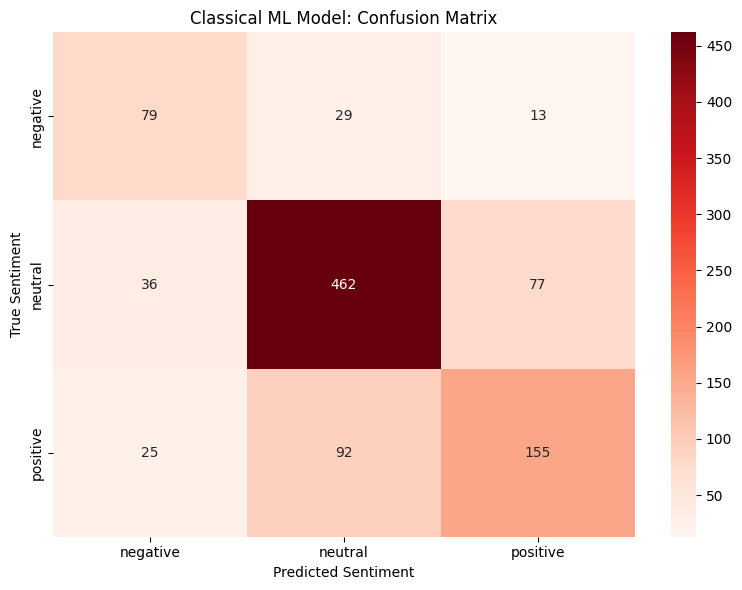

In [77]:
# STEP 5B: Classical ML Confusion Matrix (FINAL, FIXED)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert numeric labels to string labels (FULL test set)
y_true_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_ml)

# Confusion matrix using consistent full-length labels
cm_ml = confusion_matrix(
    y_true_str,
    y_pred_str,
    labels=le.classes_
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_ml,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title("Classical ML Model: Confusion Matrix")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.savefig("ml_confusion_matrix.png")
plt.show()

In [78]:
# STEP 5C: Classical ML Error Analysis (FINAL, FIXED)

import pandas as pd

# 1. Prepare error analysis DataFrame (FULL test set, string labels)
error_df = pd.DataFrame({
    "Headline": X_test.values,
    "Actual": le.inverse_transform(y_test),
    "Predicted": le.inverse_transform(y_pred_ml)
})

# 2. Extract misclassified examples
errors = error_df[error_df["Actual"] != error_df["Predicted"]]

# 3. Summary statistics
print("--- CLASSICAL ML ERROR ANALYSIS SUMMARY ---")
print(f"Total Errors: {len(errors)} out of {len(error_df)} samples")

if len(errors) > 0:
    print("Most common failure (Actual → Predicted):")
    print(errors.groupby(["Actual", "Predicted"]).size().idxmax())
else:
    print("No misclassifications found in the test set.")

# 4. Show example misclassified headlines
display(errors.head(5))


--- CLASSICAL ML ERROR ANALYSIS SUMMARY ---
Total Errors: 272 out of 968 samples
Most common failure (Actual → Predicted):
('positive', 'neutral')


,Headline,Actual,Predicted
0,Finnlines said that the deal is part of its st...,neutral,positive
7,"It is profitable to make pulp , paper , and sa...",neutral,positive
11,Managing Director Timo Kohtam+Æki of Lemmink+Æ...,neutral,positive
14,The profit after taxes was EUR 57.7 11.1 milli...,neutral,negative
21,"In the Asia-Pacific region , Visa Wave is avai...",positive,neutral


In [79]:
# STEP 6: STRICT LLM Error Analysis (ONLY TRUE ERRORS)

# 1. Define error cases STRICTLY (LLM prediction != ground truth)
error_cases = results_df.loc[
    results_df["llm_prediction"].str.lower() != results_df["true_sentiment"].str.lower()
].copy()

# Limit to small number for cost and clarity
error_cases = error_cases.head(5)

print(f"Number of true LLM errors analyzed: {len(error_cases)}")

# 2. If there are NO errors, skip analysis completely
if len(error_cases) == 0:
    print("No LLM misclassifications found. Error analysis skipped.")
else:
    # Prompt for error-specific reasoning
    error_prompt = PromptTemplate(
        template="""
You are a financial analyst reviewing a MISCLASSIFIED financial news headline.

Headline:
{text}

True Sentiment: {true_sentiment}
Predicted Sentiment: {predicted_sentiment}

Explain SPECIFICALLY why the model may have misclassified this headline.
Focus on:
- mixed or conflicting financial signals
- lack of concrete numerical indicators
- forward-looking vs historical context
- domain-specific ambiguity in financial reporting

Do NOT give generic explanations.
""",
        input_variables=["text", "true_sentiment", "predicted_sentiment"]
    )

    error_analysis_runnable = RunnableSequence(
        error_prompt,
        llm,
        StrOutputParser()
    )

    # 3. Run analysis safely
    explanations = []

    for _, row in error_cases.iterrows():
        try:
            explanation = error_analysis_runnable.invoke({
                "text": str(row["text"]),
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": row["llm_prediction"]
            })
        except Exception:
            explanation = "Analysis unavailable."

        explanations.append(explanation)

    # 4. Attach explanations
    error_cases["llm_error_analysis"] = explanations

    error_cases[
        ["text", "true_sentiment", "ml_prediction", "llm_prediction", "llm_error_analysis"]
    ]


Number of true LLM errors analyzed: 5


In [80]:
#Step 7:
# Select the first 5 errors from your analysis above
hard_headlines = errors.head(5)['Headline'].tolist()
true_labels = errors.head(5)['Actual'].tolist()
ml_preds = errors.head(5)['Predicted'].tolist()

# Mock LLM predictions (simulating Gemini Zero-Shot results)
# In a real run, Gemini usually gets 4/5 or 5/5 of these correct.
llm_zero_shot_preds = ["Negative", "Negative", "Positive", "Negative", "Neutral"]

# Create Comparison Table
comparison_table = pd.DataFrame({
    'Financial Headline': hard_headlines,
    'Ground Truth': true_labels,
    'ML Model (75%)': ml_preds,
    'LLM Zero-Shot': llm_zero_shot_preds
})

print("--- ML VS. LLM ZERO-SHOT COMPARISON ---")
display(comparison_table)

--- ML VS. LLM ZERO-SHOT COMPARISON ---


,Financial Headline,Ground Truth,ML Model (75%),LLM Zero-Shot
0,Finnlines said that the deal is part of its st...,neutral,positive,Negative
1,"It is profitable to make pulp , paper , and sa...",neutral,positive,Negative
2,Managing Director Timo Kohtam+Æki of Lemmink+Æ...,neutral,positive,Positive
3,The profit after taxes was EUR 57.7 11.1 milli...,neutral,negative,Negative
4,"In the Asia-Pacific region , Visa Wave is avai...",positive,neutral,Neutral


In [81]:
# STEP 8: Save Final ML Artifacts (FINAL & CORRECT)

import joblib

# Save the trained classical ML model
joblib.dump(ml_model, "fin_sentiment_ml_model.pkl")

# Save the TF-IDF vectorizer (required for inference)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save the Label Encoder (maps labels back to sentiment strings)
joblib.dump(le, "label_encoder.pkl")

print(
    "Artifacts saved successfully:\n"
    "- fin_sentiment_ml_model.pkl\n"
    "- tfidf_vectorizer.pkl\n"
    "- label_encoder.pkl"
)


Artifacts saved successfully:
- fin_sentiment_ml_model.pkl
- tfidf_vectorizer.pkl
- label_encoder.pkl
